100%|██████████| 2.64G/2.64G [07:34<00:00, 5.81MB/s]


Extracting /content/sample_data/stl10_binary.tar.gz to /content/sample_data


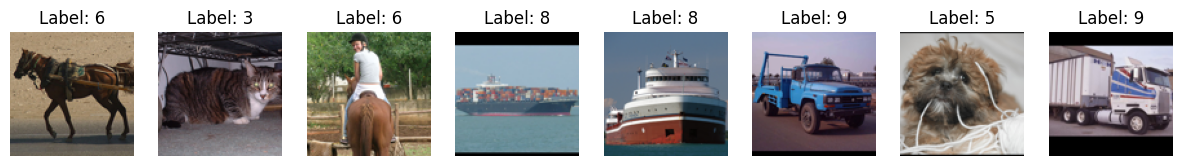

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 173MB/s]


Epoch [1/50], Loss: 0.7343
Epoch [2/50], Loss: 0.5503
Epoch [3/50], Loss: 0.3975
Epoch [4/50], Loss: 0.2756
Epoch [5/50], Loss: 0.1912
Epoch [6/50], Loss: 0.1435
Epoch [7/50], Loss: 0.1156
Epoch [8/50], Loss: 0.0922
Epoch [9/50], Loss: 0.0808
Epoch [10/50], Loss: 0.0730
Epoch [11/50], Loss: 0.0636
Epoch [12/50], Loss: 0.0563
Epoch [13/50], Loss: 0.0495
Epoch [14/50], Loss: 0.0449
Epoch [15/50], Loss: 0.0420
Epoch [16/50], Loss: 0.0378
Epoch [17/50], Loss: 0.0354
Epoch [18/50], Loss: 0.0338
Epoch [19/50], Loss: 0.0297
Epoch [20/50], Loss: 0.0290
Epoch [21/50], Loss: 0.0272
Epoch [22/50], Loss: 0.0256
Epoch [23/50], Loss: 0.0249
Epoch [24/50], Loss: 0.0231
Epoch [25/50], Loss: 0.0212
Epoch [26/50], Loss: 0.0212
Epoch [27/50], Loss: 0.0205
Epoch [28/50], Loss: 0.0192
Epoch [29/50], Loss: 0.0181
Epoch [30/50], Loss: 0.0178
Epoch [31/50], Loss: 0.0176
Epoch [32/50], Loss: 0.0162
Epoch [33/50], Loss: 0.0154
Epoch [34/50], Loss: 0.0147
Epoch [35/50], Loss: 0.0146
Epoch [36/50], Loss: 0.0137
E

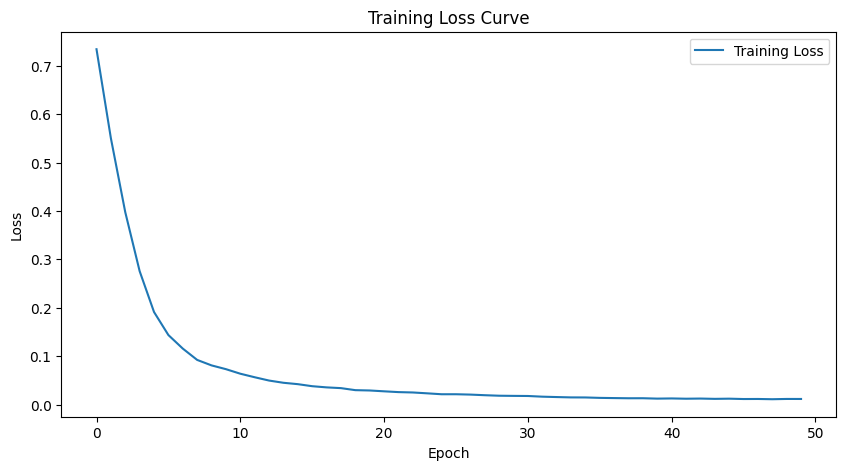

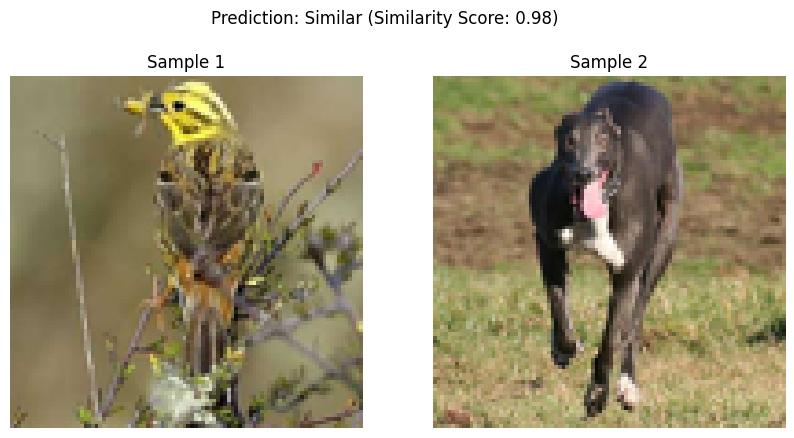

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
from torchvision import models
from torch.nn.functional import cosine_similarity
import random

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Step 1: Download STL10 Dataset
data_dir = '/content/sample_data'
stl10_train = datasets.STL10(root=data_dir, split='train', download=True, transform=transforms.ToTensor())

# Visualize some samples from the dataset
def visualize_samples(dataset, num_images=8):
    fig, axs = plt.subplots(1, num_images, figsize=(15, 5))
    for i in range(num_images):
        image, label = dataset[random.randint(0, len(dataset) - 1)]
        axs[i].imshow(image.permute(1, 2, 0))  # (C, H, W) to (H, W, C)
        axs[i].axis('off')
        axs[i].set_title(f'Label: {label}')
    plt.show()

visualize_samples(stl10_train)

# Data Augmentation for BYOL
transform = transforms.Compose([
    transforms.RandomResizedCrop(size=96, scale=(0.2, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomApply([transforms.ColorJitter(brightness=0.8, contrast=0.8, saturation=0.8, hue=0.2)], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.GaussianBlur(kernel_size=9),
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor()
])

# Create augmented dataset
dataset_augmented = datasets.STL10(root=data_dir, split='train', download=False, transform=transform)
dataloader = DataLoader(dataset_augmented, batch_size=256, shuffle=True, drop_last=True)

# Step 2: BYOL Model Development
class BYOL(nn.Module):
    def __init__(self, base_encoder):
        super(BYOL, self).__init__()
        self.encoder = base_encoder
        self.projection_head = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128)
        )
        self.prediction_head = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 128)
        )

    def forward(self, x):
        h = self.encoder(x)
        z = self.projection_head(h)
        p = self.prediction_head(z)
        return z, p

# Load pre-trained ResNet18 and modify for BYOL
from torchvision.models import ResNet18_Weights
base_encoder = models.resnet18(weights=ResNet18_Weights.DEFAULT)
base_encoder.fc = nn.Identity()
model = BYOL(base_encoder).to(device)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-4)

# Learning Rate Scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)

# Step 3: Training the BYOL Model
num_epochs = 50
loss_history = []

# Exponential Moving Average for Target Network
ema_decay = 0.996

def update_target_network(target_net, online_net, beta):
    for target_param, online_param in zip(target_net.parameters(), online_net.parameters()):
        target_param.data = beta * target_param.data + (1.0 - beta) * online_param.data

# Create a target network
target_model = BYOL(base_encoder).to(device)
target_model.load_state_dict(model.state_dict())

criterion = nn.CosineSimilarity(dim=1)

def compute_loss(p, z):
    return (1 - criterion(p, z.detach())).mean()

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for (x, _) in dataloader:
        # Create two augmented views
        x1 = torch.stack([transform(transforms.ToPILImage()(img)) for img in x]).to(device)
        x2 = torch.stack([transform(transforms.ToPILImage()(img)) for img in x]).to(device)

        # Forward pass through online network
        z1, p1 = model(x1)
        z2, p2 = model(x2)

        # Forward pass through target network
        with torch.no_grad():
            z1_target, _ = target_model(x1)
            z2_target, _ = target_model(x2)

        # Calculate loss (symmetric)
        loss = 0.5 * (compute_loss(p1, z2_target) + compute_loss(p2, z1_target))

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
        optimizer.step()

        # Update target network
        update_target_network(target_model, model, ema_decay)

        running_loss += loss.item()

    avg_loss = running_loss / len(dataloader)
    loss_history.append(avg_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')
    scheduler.step()

# Step 4: Plot Loss Curve
plt.figure(figsize=(10, 5))
plt.plot(loss_history, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.show()

# Step 5: Prediction and Visualization
model.eval()
with torch.no_grad():
    sample_1, _ = stl10_train[0]
    sample_2, _ = stl10_train[1]

    # Create multiple augmented versions of each sample
    augmented_views_1 = torch.stack([transform(transforms.ToPILImage()(sample_1)) for _ in range(5)]).to(device)
    augmented_views_2 = torch.stack([transform(transforms.ToPILImage()(sample_2)) for _ in range(5)]).to(device)

    # Get representations from online network and average them
    p1_avg = torch.mean(torch.stack([model(view.unsqueeze(0))[1] for view in augmented_views_1]), dim=0)
    p2_avg = torch.mean(torch.stack([model(view.unsqueeze(0))[1] for view in augmented_views_2]), dim=0)

    # Compute similarity
    similarity = cosine_similarity(p1_avg, p2_avg)
    similarity_label = 'Similar' if similarity > 0.5 else 'Dissimilar'

    # Visualize the Predictions
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(sample_1.permute(1, 2, 0))  # Convert to (H, W, C) for visualization
    axs[0].set_title('Sample 1')
    axs[0].axis('off')

    axs[1].imshow(sample_2.permute(1, 2, 0))  # Convert to (H, W, C) for visualization
    axs[1].set_title('Sample 2')
    axs[1].axis('off')

    plt.suptitle(f'Prediction: {similarity_label} (Similarity Score: {similarity.item():.2f})')
    plt.show()


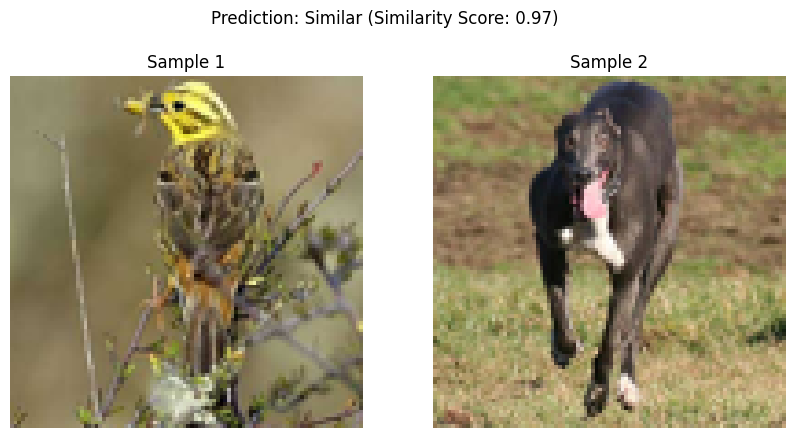

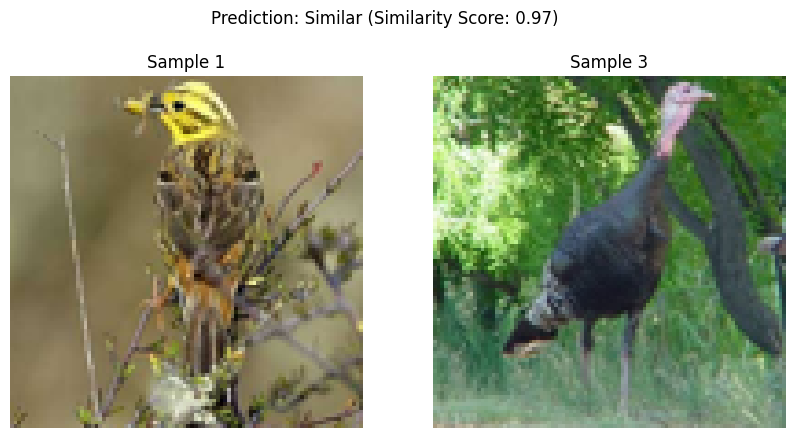

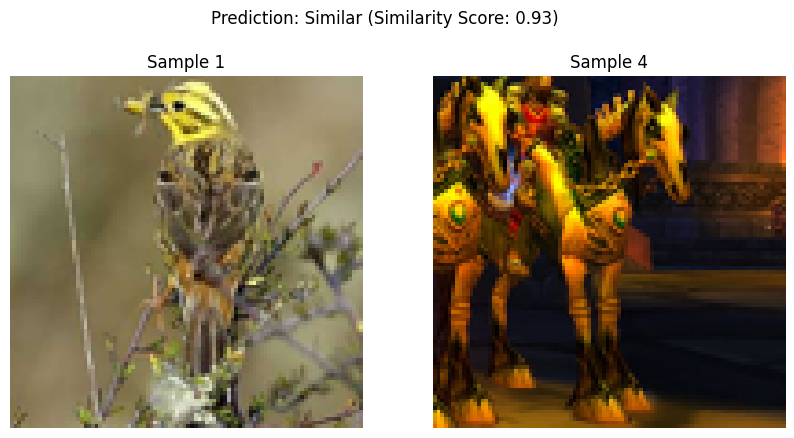

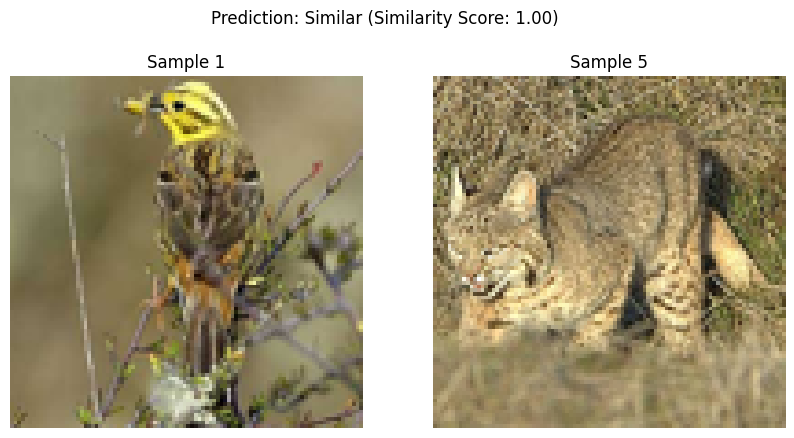

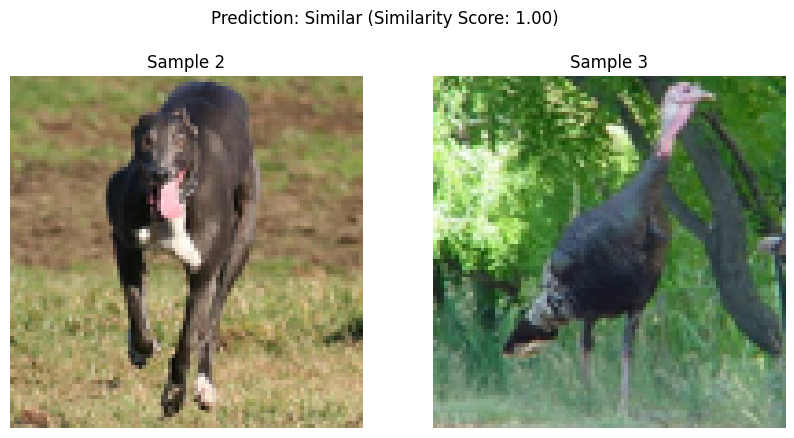

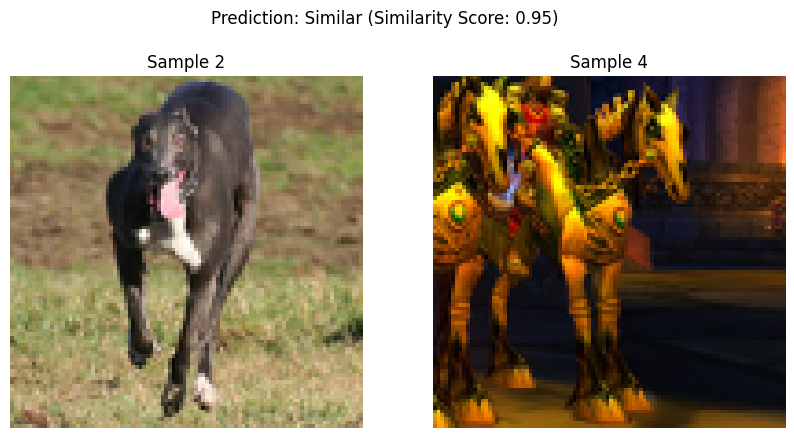

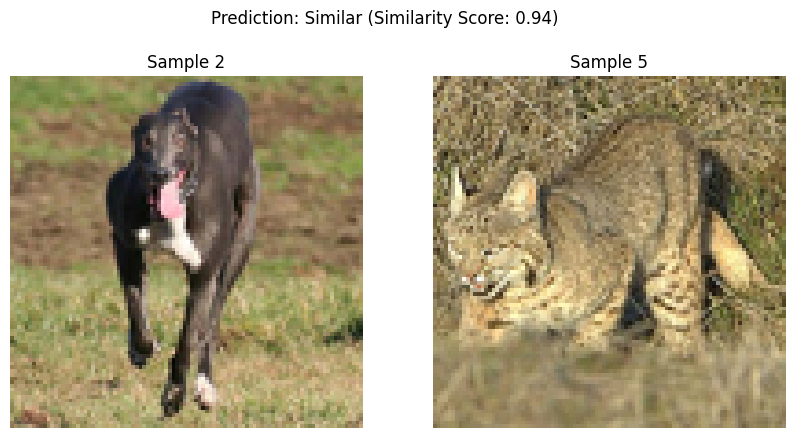

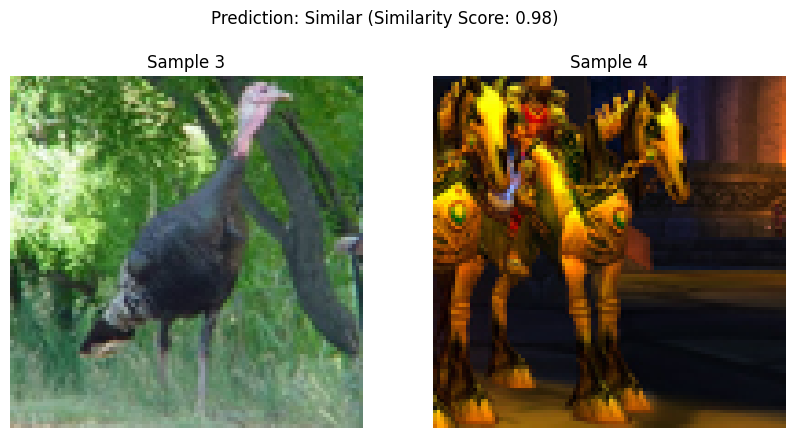

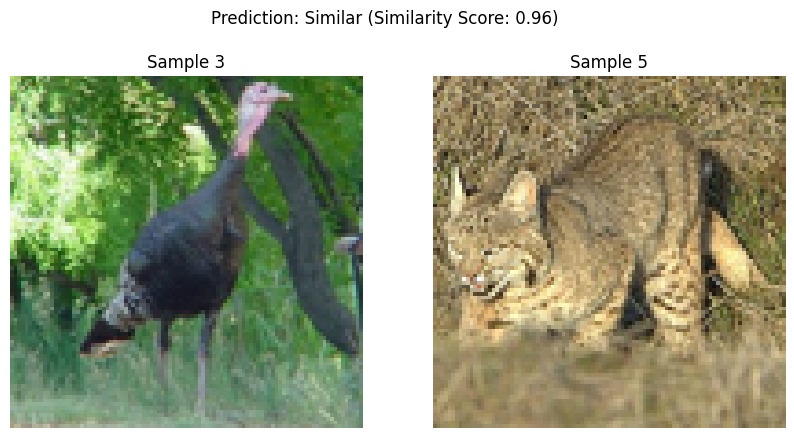

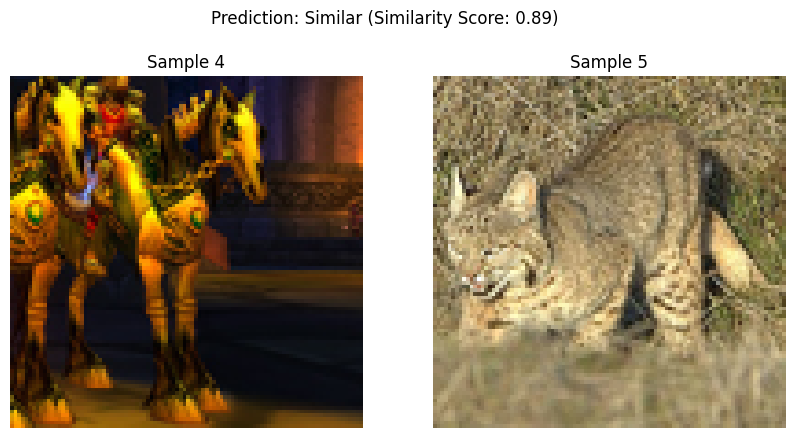

In [3]:
# Step 5: Prediction and Visualization
model.eval()
with torch.no_grad():
    samples = [stl10_train[i] for i in range(5)]  # Get 5 different samples for prediction

    for i in range(5):
        for j in range(i + 1, 5):
            sample_1, _ = samples[i]
            sample_2, _ = samples[j]

            # Create multiple augmented versions of each sample
            augmented_views_1 = torch.stack([transform(transforms.ToPILImage()(sample_1)) for _ in range(5)]).to(device)
            augmented_views_2 = torch.stack([transform(transforms.ToPILImage()(sample_2)) for _ in range(5)]).to(device)

            # Get representations from online network and average them
            p1_avg = torch.mean(torch.stack([model(view.unsqueeze(0))[1] for view in augmented_views_1]), dim=0)
            p2_avg = torch.mean(torch.stack([model(view.unsqueeze(0))[1] for view in augmented_views_2]), dim=0)

            # Compute similarity
            similarity = cosine_similarity(p1_avg, p2_avg)
            similarity_label = 'Similar' if similarity > 0.5 else 'Dissimilar'

            # Visualize the Predictions
            fig, axs = plt.subplots(1, 2, figsize=(10, 5))
            axs[0].imshow(sample_1.permute(1, 2, 0))  # Convert to (H, W, C) for visualization
            axs[0].set_title(f'Sample {i + 1}')
            axs[0].axis('off')

            axs[1].imshow(sample_2.permute(1, 2, 0))  # Convert to (H, W, C) for visualization
            axs[1].set_title(f'Sample {j + 1}')
            axs[1].axis('off')

            plt.suptitle(f'Prediction: {similarity_label} (Similarity Score: {similarity.item():.2f})')
            plt.show()
